In [1]:
# first import embedding, standardization, compute a stacked bargraph showing the proportion of a vector's magnitude from 
import pandas as pd
from src.constants import Column
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import mplscience
mplscience.available_styles()
mplscience.set_style(reset_current=True)

['default', 'despine']


### load univariate pvalue from cell profiler

In [2]:
cp_univariate = pd.read_parquet('funk22-cellprofiler-univariate-ipca90.parquet')

In [3]:
SIG_sgRNA = list(cp_univariate.loc[(cp_univariate['pvalue']<0.01) | (cp_univariate['gene_symbol_0']=='nontargeting'), 'sgRNA_0'])

pvalues = np.array([v["pvalue"] for k, v in cp_univariate.iterrows() if v['gene_symbol_0']!='nontargeting'])
n_significant = np.sum(pvalues < 0.01)

n_significant, n_significant / len(pvalues)

(7040, 0.34860113889576627)

In [4]:
root = '/home/wangz222/scratch/embedding'
df = pd.read_pickle(f'{root}/ctvae-conditional_contrastive_model-44m9h8fu:v0.pkl')
df = df[df['sgRNA_0'].isin(SIG_sgRNA)]
df_agg = df.groupby(Column.sgRNA.value).agg({col: 'mean' if col != Column.gene.value else 'first' for col in df.columns[1:]}).groupby(Column.gene.value).mean()
df_standardized = df_agg - df_agg.loc['nontargeting']

In [6]:
df_agg.columns = df_agg.columns.astype(str)
df_agg.to_parquet('/gstore/data/ctgbioinfo/kudot3/romain/df_agg_44m9h8fu.parquet', compression='snappy')

In [7]:
metadata = pd.read_pickle('/home/wangz222/scratch/splits_shuffled/filtered_df.pkl')
metadata = metadata[metadata[Column.sgRNA.value].isin(SIG_sgRNA)]
def compute_proportion(series):
    counts = series.value_counts(normalize=True)
    return counts
mitotic_index = metadata.groupby(Column.gene.value)[Column.cell_cycle_stage.value].apply(compute_proportion).unstack().fillna(0)
ntc_mitotic_index = mitotic_index.loc['nontargeting', 'mitotic']
mitotic_index = (mitotic_index['mitotic']-ntc_mitotic_index)/ntc_mitotic_index * 100

In [8]:
np.mean(ntc_mitotic_index)

0.02657922376010739

76.53713498141317


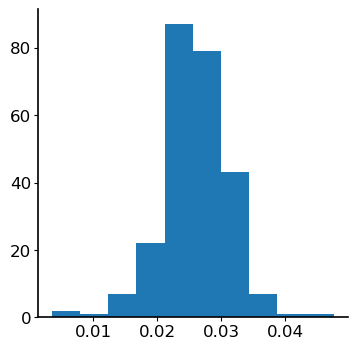

In [9]:
ntc_mitotic = metadata[metadata['gene_symbol_0']=='nontargeting'].groupby('sgRNA_0')['stage'].value_counts(normalize=True).unstack()['mitotic']
plt.hist(ntc_mitotic)
limit_mitotic_index = (ntc_mitotic.quantile(0.999) - np.mean(ntc_mitotic))/np.mean(ntc_mitotic) * 100
print(limit_mitotic_index)

In [13]:
ntc_mitotic.to_csv('/gstore/data/ctgbioinfo/kudot3/romain/ntc_mitotic.csv')

In [ ]:
mitotic_index.to_csv('/gstore/data/ctgbioinfo/kudot3/romain/mitotic_index.csv')

In [9]:
df_standardized['salient_mag'] = np.linalg.norm(df_standardized.iloc[:,:32], axis=1)**2
df_standardized['background_mag']  = np.linalg.norm(df_standardized.iloc[:,32:64], axis=1)**2

df_standardized['salient_mag'] = df_standardized['salient_mag']/np.mean(df_standardized['salient_mag'])
df_standardized['background_mag'] = df_standardized['background_mag']/np.mean(df_standardized['background_mag'])

df_standardized['background_contribution'] = df_standardized['background_mag']/(df_standardized['salient_mag']+df_standardized['background_mag'])
df_standardized['mitotic_index'] = np.abs(mitotic_index)


In [14]:
df_standardized.columns = df_standardized.columns.astype(str)

In [15]:
df_standardized.to_parquet('df_standardized_mitosis.parquet', compression='snappy')

In [ ]:
df_standardized.drop('nontargeting', inplace=True)

In [15]:
mitotic_factor = [
    'ANAPC11', 'ORC5', 'CENPK', 'CENPE', 'RBBP4',
    'CENPM', 'STIL', 'TOP2A', 'ORC4', 'WEE1', 'SKA3', 'CDC14B', 'CDC26',  'BUB3', 'CDC7', 'NDC80',
    'SFN', 'WAPL', 'CENPC', 'PRKDC', 'SMC2', 'WEE2', 'SMAD3', 'ANAPC1', 'INCENP', 'KIF11', 'TUBA1B',
    'CDKN2A','CDC14A', 'DBF4', 'MAD2L1', 'HAUS6', 'AURKA', 'LIN54', 'ANAPC13', 'BUB1B', 'HAUS3',
    'NCAPG', 'ANLN', 'CKAP5', 'ORC1', 'FBXW7', 'CDC25A', 'CENPA', 'NCAPD2', 'ABL1', 'CCNA1',
    'CUL1', 'RBL1', 'KIF14', 'MAD2L2', 'CENPH', 'CENPW', 'NEK6', 'UBE2I', 'ORC2', 'UBE2D3', 'LIN37',
    'KIF18A', 'TUBB4B', 'TUBG1', 'AURKB', 'PLK1', 'SKA1', 'CENPF', 'CDC23', 'CDC25B', 'NEDD1', 'CENPJ',
    'SKA2',  'ANAPC5', 'CDC45', 'LIN9', 'KNTC1', 'SMC1B', 'HAUS5', 'STAG2', 'SASS6', 'ECT2',
    'ANAPC10', 'SPDL1', 'SPC25', 'ANAPC7', 'CCNF', 'CENPI', 'HAUS1', 'KIF23', 'TTK', 'SKP1', 'ESPL1',
    'SPC24', 'SKP2', 'STAG1', 'NUF2', 'RACGAP1', 'SMC1A', 'BUB1', 'CCNB2', 'KIF20A',
    'RAD21', 'CDC20', 'NUDC', 'CDC16', 'TUBGCP6', 'CDK2', 'CCNA2', 'FZR1', 'NIPBL', 'PTTG1', 'HAUS7',
    'CDCA5', 'CHEK1', 'ANAPC4', 'CENPP', 'CENPL', 'CDC27', 'CCNB1', 'CEP192', 'PKMYT1', 'CENPN', 'PLK4',
    'NCAPH2', 'PRC1', 'HDAC1', 'HAUS2', 'HAUS8', 'SMC3', 'NUMA1', 'CDC25C', 'ANAPC2', 'CHEK2', 'CDCA8',
    'MAD1L1', 'HAUS4', 'CCNB3', 'LIN52', 'BIRC5', 'TACC3', 'SGO1', 'CDK7', 'CEP55','BORA','SRSF1',
    'PRPF40A', 'ERH', 'CDK1', 
]

# cell_cycle_factor = [
#     'ZBTB17', 'TFDP1', 'RBX1', 'CDK1', 'ANAPC11', 'ATM', 'E2F2', 'ORC5', 'MCM6', 
#     'SMAD2', 'CCNH', 'MCM9', 'SMARCA4', 'CENPK', 'CENPE', 'RBBP4', 'GADD45B', 'MYC', 
#     'CENPM', 'STIL', 'TOP2A', 'ORC4', 'WEE1', 'SKA3', 'CDC14B', 'YWHAG', 'CDC26', 
#     'YWHAH', 'BUB3', 'CDC7', 'NDC80', 'SFN', 'WAPL', 'CENPC', 'PRKDC', 'SMC2', 'E2F5', 
#     'WEE2', 'SMAD3', 'ANAPC1', 'INCENP', 'TBCC', 'KIF11', 'TUBA1B', 'CDKN2A', 'CCND3', 
#     'CDC14A', 'DBF4', 'MAD2L1', 'HAUS6', 'AURKA', 'LIN54', 'E2F1', 'ANAPC13', 'BUB1B', 
#     'GADD45G', 'TGFB1', 'HAUS3', 'NCAPG', 'ANLN', 'CKAP5', 'ORC1', 'FBXW7', 'MCM4', 
#     'TUBB', 'CDC25A', 'CENPA', 'NCAPD2', 'MCM10', 'ABL1', 'CCNA1', 'CUL1', 'RBL1', 
#     'TGFB3', 'KIF14', 'TGFB2', 'MAD2L2', 'CENPH', 'CENPW', 'NEK6', 'UBE2I', 'ORC2', 
#     'YWHAB', 'UBE2D3', 'LIN37', 'CDC6', 'KIF18A', 'TP53', 'TUBB4B', 'TUBG1', 'HDAC2', 
#     'AURKB', 'PLK1', 'E2F3', 'SKA1', 'CENPF', 'CDC23', 'RB1', 'CDC25B', 'PCNA', 'NEDD1', 
#     'BTAF1', 'LENG8', 'CCND1', 'CENPJ', 'SKA2', 'MCM7', 'CDKN2B', 'CCND2', 'TFDP2', 
#     'TUBA1C', 'TUBB8', 'ANAPC5', 'CDC45', 'LIN9', 'KNTC1', 'SMC1B', 'CDKN1B', 'HAUS5', 
#     'CIT', 'STAG2', 'ECT2', 'SASS6', 'ANAPC10', 'SPDL1', 'ZNF207', 'SPC25', 'ANAPC7', 
#     'CCNF', 'RBBP7', 'TUBB8B', 'CENPI', 'TUBA3D', 'CCNE2', 'HAUS1', 'KIF23', 'TTK', 
#     'SKP1', 'ORC3', 'TUBA1A', 'ESPL1', 'SPC24', 'SKP2', 'STAG1', 'NUF2', 'SRCAP', 
#     'RACGAP1', 'ATR', 'CDKN2C', 'SMC1A', 'ORC6', 'MCM5', 'MAU2', 'TUBGCP3', 'CCNE1', 
#     'BUB1', 'MCM2', 'PTTG2', 'CCNB2', 'KIF20A', 'RAD21', 'TUBB2A', 'CDKN2D', 'CDC20', 
#     'NUDC', 'CDC16', 'TUBGCP6', 'MCM3', 'YWHAE', 'CDK2', 'CCNA2', 'FZR1', 'NIPBL', 
#     'TUBGCP2', 'PTTG1', 'CDCA5', 'HAUS7', 'CHEK1', 'ANAPC4', 'CDK4', 'CENPP', 'CENPL', 
#     'SMAD4', 'MDM2', 'CDC27', 'CCNB1', 'YWHAQ', 'CEP192', 'CDKN1A', 'PKMYT1', 'CENPN', 
#     'PLK4', 'MYBL2', 'NCAPH2', 'PRC1', 'CDK6', 'HDAC1', 'HAUS2', 'E2F4', 'HAUS8', 'SMC3', 
#     'NUMA1', 'CDC25C', 'ANAPC2', 'CHEK2', 'CDCA8', 'YWHAZ', 'MAD1L1', 'GSK3B', 'CDC5L', 
#     'HAUS4', 'CCNB3', 'CDKN1C', 'RBL2', 'LIN52', 'GADD45A', 'BIRC5', 'TACC3', 'SGO1', 
#     'CDK7', 'CEP55'
# ]
genes_involved_in_mitosis_and_cell_cycle = [gene for gene in mitotic_factor if gene in list(df_standardized.index)]


### change order of points so the established mitotic factors are always plotted first

In [ ]:
df_standardized['label'] = ''
df_standardized.loc[genes_involved_in_mitosis_and_cell_cycle, 'label'] = 'established mitotic factor'
df_standardized.loc[df_standardized['label'] != 'established mitotic factor', 'label'] = 'Other'

labels_order = ['Other', 'established mitotic factor']
df_standardized['label'] = df_standardized['label'].astype('category')
df_standardized['label'].cat.set_categories(labels_order, ordered=True, inplace=True)
df_standardized.sort_values('label', inplace=True)

In [ ]:
plt.figure(dpi=400)
temp = pd.concat([np.log10(df_standardized[["salient_mag", "background_mag"]]), df_standardized['label']], axis=1)
g = sns.JointGrid(data=temp, x="salient_mag", y="background_mag", hue='label')
g = g.plot_joint(sns.scatterplot, s=22)
g = g.plot_marginals(sns.kdeplot, fill=True, common_norm=False)

g.ax_joint.plot([-1.5,2.4],[-1.5,2.4], c='gray')
g.ax_joint.set_xlabel(r'$\log(\|salient\|^2)$', fontsize=12)
g.ax_joint.set_ylabel(r'$\log(\|background\|^2)$', fontsize=12)
g.ax_joint.set_ylim(-1.5,1.8)
g.ax_joint.set_xlim(-1.5,1.8)
legend = g.ax_joint.get_legend()
legend.set_title('')
plt.savefig('figure/figure_4/mitotic_factor_norm.svg', bbox_inches='tight')

In [ ]:
df_standardized['label'] = ''
df_standardized.loc[genes_involved_in_mitosis_and_cell_cycle, 'label'] = 'established mitotic factor'
df_standardized.loc[df_standardized['label'] != 'established mitotic factor', 'label'] = 'Other'
df_standardized.loc[df_standardized['mitotic_index']<limit_mitotic_index, 'label'] = 'non-significant'

labels_order = ['non-significant', 'Other', 'established mitotic factor']
df_standardized['label'] = df_standardized['label'].astype('category')
df_standardized['label'].cat.set_categories(labels_order, ordered=True, inplace=True)
df_standardized.sort_values('label', inplace=True)

In [ ]:
palette = {
    "non-significant": "lightgray",
    "Other": "tab:blue",
    "established mitotic factor": "tab:orange"
}

g = sns.JointGrid(data=df_standardized, x="mitotic_index", y="background_contribution", hue="label", palette=palette)
g = g.plot_joint(sns.scatterplot, data=df_standardized, s=22)
# g = g.plot_marginals(sns.kdeplot, data=df_standardized[df_standardized['label'] != 'non-significant'], fill=True, common_norm=False)
df_other = df_standardized[df_standardized['label'] == 'Other']
df_established = df_standardized[df_standardized['label'] == 'established mitotic factor']

# Manually add the KDE plots for the labels you want
sns.kdeplot(data=df_other, x="mitotic_index", fill=True, common_norm=False, ax=g.ax_marg_x)
sns.kdeplot(data=df_other, y="background_contribution", fill=True, common_norm=False, ax=g.ax_marg_y)

sns.kdeplot(data=df_established, x="mitotic_index", fill=True, common_norm=False, ax=g.ax_marg_x)
sns.kdeplot(data=df_established, y="background_contribution", fill=True, common_norm=False, ax=g.ax_marg_y)


g.ax_joint.set_ylabel(r'$\frac{\|background\|^2}{\|background\|^2 + \|salient\|^2}$', fontsize=16)
g.ax_joint.set_xlabel('mitotic index', fontsize=14)
g.ax_joint.set_ylim(0.,1)
g.ax_joint.set_xlim(0, 1150)
g.ax_joint.legend(frameon=False)
legend = g.ax_joint.get_legend()

# Remove the legend title
legend.set_title('')
g.ax_joint.axhline(0.5, color='k', linestyle='--')
plt.savefig('figure/figure_4/mitotic_index_norm_ratio.svg')

In [ ]:
from sklearn.metrics import roc_curve, auc

# Assuming you have a DataFrame called df with columns 'v1', 'v2', and 'label'
# Convert the label to a binary encoding if it's not already
df = pd.concat([df_other[['background_contribution','mitotic_index','label']], df_established[['background_contribution','mitotic_index','label']]])
df['label'] = (df['label'] == 'established mitotic factor').astype(int)  # Replace 'positive_label' with the actual positive class label

# Compute ROC curve for v1
fpr_v1, tpr_v1, _ = roc_curve(df['label'], df['background_contribution'])
roc_auc_v1 = auc(fpr_v1, tpr_v1)

# Compute ROC curve for v2
fpr_v2, tpr_v2, _ = roc_curve(df['label'], df['mitotic_index'])
roc_auc_v2 = auc(fpr_v2, tpr_v2)

# Plot ROC curve for v1
plt.figure()
plt.plot(fpr_v1, tpr_v1, color='blue', lw=2, label='relative background norm (area = %0.2f)' % roc_auc_v1)

# Plot ROC curve for v2
plt.plot(fpr_v2, tpr_v2, color='green', lw=2, label='mitotic index (area = %0.2f)' % roc_auc_v2)

# Plot random guessing line
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#remove top and right spline
plt.savefig('figure/figure_4/roc_curve.svg', bbox_inches='tight')
plt.show()
